In [1]:
from pprint import pprint

import numpy as np

import wandb
import pdb
import traceback

import jax
from jax import numpy as jnp
import optax

from common_dl_utils.config_creation import Config
import common_jax_utils as cju

import common_dl_utils as cdu
from common_dl_utils.config_creation import Config, VariableCollector

wandb.login()
key = jax.random.PRNGKey(123)
key_gen = cju.key_generator(key)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxwell_litsios (bep-circle). Use `wandb login --relogin` to force relogin
2024-10-09 13:34:21.881138: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# model definition

In [13]:

config = Config()

config.architecture = "./model_components"
config.model_type = 'inr_modules.CombinedINR'


config.model_config = Config()

config.model_config.in_size = 2
config.model_config.out_size = 3

config.model_config.terms = [
    (
        "inr_modules.MLPINR.from_config", {
        "hidden_size":512,
        "num_layers":5,
        "layer_type": "inr_layers.ComplexWire",
        "num_splits":1,
        "use_complex":False,
        "activation_kwargs": {"w0": 12, "s0": 1}
    })
]


# training config

In [14]:
config.trainer_module = "./inr_utils/"
config.trainer_type = "training.train_inr"
config.target_function = "images.ContinuousImage"

config.target_function_config = {
    "image": "./example_data/parrot.png",
    "scale_to_01":True,
    "interpolation_method":"images.make_piece_wise_constant_interpolation"
}

config.loss_function = 'losses.scaled_mse_loss'
config.sampler = ('sampling.GridSubsetSampler',{  # samples coordinates in a fixed grid, that should in this case coincide with the pixel locations in the image
    'size': [2040, 1356],
    'batch_size': 2000,
    'allow_duplicates': False,
})

config.optimizer = 'adam'  # we'll have to add optax to the additional default modules later
config.optimizer_config = {
    'learning_rate': 1.5e-4
}


config.steps = 10000
config.use_wandb = True

# now we want some extra things, like logging, to happen during training
# the inr_utils.training.train_inr function allows for this through callbacks.
# The callbacks we want to use can be found in inr_utils.callbacks
config.after_step_callback = 'callbacks.ComposedCallback'
config.after_step_callback_config = {
    'callbacks':[
        ('callbacks.print_loss', {'after_every':400}),  # only print the loss every 400th step
        'callbacks.report_loss',  # but log the loss to wandb after every step
        ('callbacks.MetricCollectingCallback', # this thing will help us collect metrics and log images to wandb
             {'metric_collector':'metrics.MetricCollector'}
        ),
        'callbacks.raise_error_on_nan'  # stop training if the loss becomes NaN
    ],
    'show_logs': False
}

config.metric_collector_config = {  # the metrics for MetricCollectingCallback / metrics.MetricCollector
    'metrics':[
        ('metrics.PlotOnGrid2D', {'grid': 256, 'batch_size':8*256, 'frequency':'every_n_batches'}),  
        # ^ plots the image on this fixed grid so we can visually inspect the inr on wandb
        ('metrics.MSEOnFixedGrid', {'grid': [2040, 1356], 'batch_size':2040, 'frequency': 'every_n_batches'})
        # ^ compute the MSE with the actual image pixels
    ],
    'batch_frequency': 400,  # compute all of these metrics every 400 batches
    'epoch_frequency': 1  # not actually used
}

config.after_training_callback = None  # don't care for one now, but you could have this e.g. store some nice loss plots if you're not using wandb 
config.optimizer_state = None  # we're starting from scratch

In [15]:
# let's first see if we get the correct model
try:
    inr = cju.run_utils.get_model_from_config_and_key(
        prng_key=next(key_gen),
        config=config,
        model_sub_config_name_base='model',
        add_model_module_to_architecture_default_module=False, # since the model is already in the default module specified by 'architecture',
    )
except Exception as e:
    traceback.print_exc()
    print(e)
    print('\n')
    pdb.post_mortem()

In [16]:
inr


CombinedINR(
  terms=(
    MLPINR(
      input_layer=ComplexWire(
        weights=f32[512,2],
        biases=f32[512],
        activation_kwargs={'w0': 12, 's0': 1}
      ),
      hidden_layers=[
        ComplexWire(
          weights=f32[512,512],
          biases=f32[512],
          activation_kwargs={'w0': 12, 's0': 1}
        ),
        ComplexWire(
          weights=f32[512,512],
          biases=f32[512],
          activation_kwargs={'w0': 12, 's0': 1}
        ),
        ComplexWire(
          weights=f32[512,512],
          biases=f32[512],
          activation_kwargs={'w0': 12, 's0': 1}
        )
      ],
      output_layer=Linear(
        weights=f32[3,512],
        biases=f32[3],
        activation_kwargs={}
      ),
      post_processor=<function real_part>
    ),
  ),
  post_processor=<function real_part>
)

In [18]:
experiment = cju.run_utils.get_experiment_from_config_and_key(
    prng_key=next(key_gen),
    config=config,
    model_kwarg_in_trainer='inr',
    model_sub_config_name_base='model',  # so it looks for "model_config" in config
    trainer_default_module_key='trainer_module',  # so it knows to get the module specified by config.trainer_module
    additional_trainer_default_modules=[optax],  # remember the don't forget to add optax to the default modules? This is that 
    add_model_module_to_architecture_default_module=False,
    initialize=False  # don't run the experiment yet, we want to use wandb
)

/home/ovindar/PycharmProjects/INR_BEP/.venv/lib/python3.10/site-packages/jax/_src/lax/lax.py:3227: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Loss at step 400 is 0.23753859102725983.
Loss at step 800 is 0.17240950465202332.
Loss at step 1200 is 0.17338517308235168.
Loss at step 1600 is 0.13816608488559723.
Loss at step 2000 is 0.14387619495391846.
Loss at step 2400 is 0.12242170423269272.
Loss at step 2800 is 0.1180521547794342.
Loss at step 3200 is 0.10810013860464096.
Loss at step 3600 is 0.10784098505973816.
Loss at step 4000 is 0.11602301895618439.
Loss at step 4400 is 0.09595547616481781.
Loss at step 4800 is 0.10572443902492523.
Loss at step 5200 is 0.08449115604162216.
Loss at step 5600 is 0.10581201314926147.
Loss at step 6000 is 0.09425991773605347.
Loss at step 6400 is 0.09983878582715988.
Loss at step 6800 is 0.0859023854136467.
Loss at step 7200 is 0.09281058609485626.
Loss at step 7600 is 0.08459315448999405.
Loss at step 8000 is 0.08344407379627228.
Loss at step 8400 is 0.0762539803981781.
Loss at step 8800 is 0.09273675084114075.
Loss at step 9200 is 0.09298018366098404.
Loss at step 9600 is 0.0929533466696739

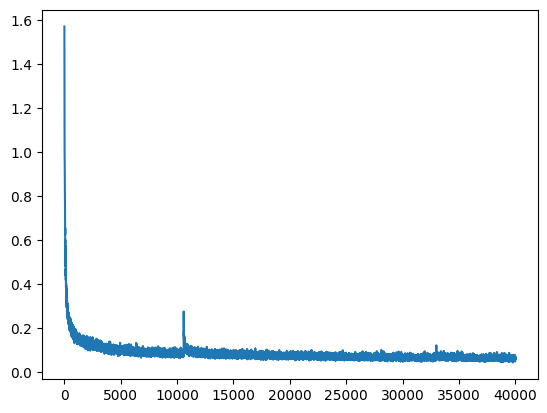

MSE_on_fixed_grid,█▆▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_within_epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇██
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▆▇▅▃▃▄▅▅▃▂▃▃▃▃▂▂▂▃▂▁▁▂▁▂▁▁▂▁▂▂▂▃▂▂▂▁▂▃
MSE_on_fixed_grid,0.00888
batch_within_epoch,40000
epoch,1
loss,0.05923


In [19]:
with wandb.init(
    project='inr_edu_24',
    notes='test',
    tags=['test']
) as run:
    results = experiment.initialize()